## 🌟 Leaderboard Introduction

In a world where research grows faster than we can read, **RESONATE** bridges the gap between curiosity and clarity.  
Powered by a network of collaborating **AI agents**, it listens, interprets, and connects scattered research insights into a living web of knowledge.  
From raw abstracts to structured summaries and knowledge graphs — RESONATE doesn’t just analyze papers, it **understands ideas and how they resonate together**.


# 🌐 RESONATE: AI Research Exploration Assistant  

![RESONATE Banner](resonate_banner.png)

**RESONATE** is a multi-agent AI system that transforms research-style texts into structured knowledge.  
It uses collaborating agents to ingest data, summarize papers, tag topics, link related works, build a knowledge graph, and generate a final report.


## 🧭 Table of Contents

1. [Introduction & Motivation](#introduction--motivation)  
2. [Methodology & System Design](#methodology--system-design)  
3. [Step 1 — Setup & Demo Data](#step-1--setup--demo-data)  
4. [Step 2 — LLM Client & Reasoning Stub](#step-2--llm-client--reasoning-stub)  
5. [Step 3 — Designing RESONATE Agents](#step-3--designing-resonate-agents)  
6. [Step 4 — Orchestrator: Wiring Agents Together](#step-4--orchestrator-wiring-agents-together)  
7. [Step 5 — Running RESONATE End-to-End](#step-5--running-resonate-end-to-end)  
8. [Results & Interpretation](#results--interpretation)  
9. [Visual Assets & Image Prompts](#visual-assets--image-prompts)  
10. [Conclusion & Acknowledgments](#conclusion--acknowledgments)  
11. [Final Thoughts — Let Ideas Resonate](#final-thoughts--let-ideas-resonate)  


## Introduction & Motivation

Modern AI research moves incredibly fast. New papers on LLMs, agents, and reasoning come out daily.  
Even for experienced practitioners, it is difficult to:

- Read everything  
- Remember the key ideas  
- See how concepts connect across papers  

**Goal of this notebook**

Build a compact but complete demo of an **AI Agents system** that:

- Takes in a small corpus of research-style texts  
- Summarizes them into structured fields (Problem, Approach, Results, TL;DR)  
- Connects them into a **knowledge graph**  
- Generates a human-readable Markdown report  

All of this is done via a **multi-agent pattern**: each agent has one job, and an orchestration layer coordinates them.


   Methodology & System Design

At a high level, RESONATE follows this agent pipeline:

1. **Paper Ingestion Agent**  
   - Normalizes raw input and combines title + abstract into `clean_text`.  

2. **Paper Summary Agent (LLM-backed)**  
   - Uses an LLM (here: a dummy but structured stub)  
   - Produces a JSON summary with fields: `problem`, `approach`, `results`, `tl_dr`.  

3. **Topic Tag Agent**  
   - Attaches a lightweight topic structure (main topic, subtopics, keywords).  

4. **Paper Linker Agent**  
   - Creates edges between related papers (here: fully connected for demonstration).  

5. **Graph Builder Agent**  
   - Builds a NetworkX graph with nodes = papers, edges = relationships.  

6. **Report Agent**  
   - Generates a Markdown report summarizing the corpus and graph.  

The whole flow is coordinated by an **Orchestrator**, which calls each agent in order.

---

## 🧩 RESONATE Architecture Diagram  

![RESONATE Architecture Diagram](resonate_architecture.png)

The RESONATE system follows a modular, multi-agent pipeline design:
1. **Data Ingestion** – Collect and normalize research-style texts.  
2. **Summarization** – Generate structured, JSON-formatted summaries.  
3. **Topic Tagging** – Identify main research domains and subtopics.  
4. **Linking** – Discover inter-paper connections.  
5. **Knowledge Graph** – Visualize relational structure.  
6. **Report Generation** – Compile the summarized insights.





## Step 1 — Setup & Demo Data

In this step we:

- Import core Python libraries:
  - `json` for working with structured data
  - `itertools.combinations` for generating paper pairs
  - `networkx` and `matplotlib` for graph visualization
  - `IPython.display` for rendering Markdown in outputs
- Define a tiny demo corpus of 5 "papers", each with:
  - `id`
  - `title`
  - `abstract`

This dataset is intentionally small so that the focus stays on the **multi-agent pipeline**, not data wrangling.


In [1]:
# 1. Imports and Demo Data

import json
from typing import Callable, List
from itertools import combinations

import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Small demo corpus of research-style entries
raw_papers = [
    {
        "id": 1,
        "title": "Beyond Transformers: Efficient Long-Context Modeling",
        "abstract": "Explores efficient long-context modeling using sparse attention and memory mechanisms."
    },
    {
        "id": 2,
        "title": "Aligning LLMs via Reinforcement Learning",
        "abstract": "Uses reinforcement learning from human feedback to align large language models with human preferences."
    },
    {
        "id": 3,
        "title": "Benchmarking Reasoning in LLMs",
        "abstract": "Evaluates reasoning skills of large language models on logical and multi-step tasks."
    },
    {
        "id": 4,
        "title": "Retrieval-Augmented Generation",
        "abstract": "Combines retrieval and generation for factual question answering and grounded responses."
    },
    {
        "id": 5,
        "title": "Tool-Using Agents",
        "abstract": "Enables language models to call external tools and APIs to accomplish complex tasks."
    }
]

print(f"Loaded {len(raw_papers)} papers.")
print("Keys in each paper:", list(raw_papers[0].keys()))


Loaded 5 papers.
Keys in each paper: ['id', 'title', 'abstract']


In [2]:
import google.generativeai as genai
print("google-generativeai imported successfully. Version:", genai.__version__)


google-generativeai imported successfully. Version: 0.8.5


In [3]:
!pip install -q google-generativeai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 wh

In [4]:
import os
import shutil

src_dir = "/kaggle/input/pictures-1"  # your dataset name

print("Files in dataset:", os.listdir(src_dir))

# Adjust these names if they look slightly different in the print above
shutil.copy(os.path.join(src_dir, "Resonate_Banner.png"),
            "/kaggle/working/resonate_banner.png")

shutil.copy(os.path.join(src_dir, "Resonate_Architecture.png"),
            "/kaggle/working/resonate_architecture.png")

print("Files now in /kaggle/working:", os.listdir("/kaggle/working"))


Files in dataset: ['Resonate_Banner.png', 'Resonate_Architecture.png']
Files now in /kaggle/working: ['resonate_banner.png', 'resonate_architecture.png', '__notebook__.ipynb']


## Step 2 — LLM Client & Reasoning Stub

In a real deployment, RESONATE would call an actual LLM service (OpenAI, Anthropic, Gemini, etc.).  

To keep this notebook fully reproducible and offline, we:

- Implement `LLMClient`, a light wrapper for any callable model function.  
- Implement `dummy_model_call(prompt)`, a smart stub that:
  - Looks for keywords in the text  
  - Returns a structured JSON summary with:
    - `problem`
    - `approach`
    - `results`
    - `tl_dr`
  - Always returns **valid JSON**, so `json.loads(...)` never fails.

You can later replace `dummy_model_call` with a real LLM API while keeping the rest of the pipeline unchanged.


In [5]:
# 2. LLM Client using Google Gemini API (Secure + Simple Fallback)

import re
import json
import time  # not really needed now, but OK to keep

import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# --- 2.1 Load Gemini API key securely from Kaggle Secrets ---

user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GEMINI_API_KEY")

if not api_key:
    raise ValueError(
        "GEMINI_API_KEY not found in Kaggle Secrets. "
        "Add it under Notebook → Settings → Secrets before running this cell."
    )

# Configure Gemini with the secret key
genai.configure(api_key=api_key)

# Use one of your available models that supports generateContent (from list_models())
MODEL_NAME = "models/gemini-2.5-pro"  # or "models/gemini-2.5-flash"


# --- 2.2 Helper: clean model output into raw JSON text ---

def _clean_json_text(text: str) -> str:
    """
    Remove Markdown formatting or code fences from model output and return raw JSON text.
    """
    text = text.strip()
    if text.startswith("```"):
        text = re.sub(r"^```(json)?", "", text, flags=re.IGNORECASE).strip()
        text = re.sub(r"```$", "", text).strip()
    return text


# --- 2.3 Offline fallback summarizer (no API needed) ---

def offline_fallback_summary(prompt: str) -> str:
    """
    Deterministic offline backup if Gemini fails (e.g., rate limits).
    Returns a JSON string with keys: problem, approach, results, tl_dr.
    Uses simple keyword heuristics on the input.
    """
    text = prompt.lower()
    if "long-context" in text or "transformer" in text:
        data = {
            "problem": "Standard transformers are inefficient on very long sequences.",
            "approach": "Use sparse attention and memory mechanisms to handle longer contexts.",
            "results": "Improves efficiency and scalability for long-context tasks.",
            "tl_dr": "Efficient long-context modeling with sparse attention and memory."
        }
    elif "reinforcement" in text or "rlhf" in text or "aligning" in text:
        data = {
            "problem": "LLMs may produce unsafe or misaligned outputs.",
            "approach": "Use reinforcement learning from human feedback (RLHF) to align behavior.",
            "results": "Produces outputs more consistent with human preferences and safety constraints.",
            "tl_dr": "RLHF aligns LLM behavior with human values."
        }
    elif "reasoning" in text or "logical" in text:
        data = {
            "problem": "Reasoning ability in LLMs is hard to evaluate objectively.",
            "approach": "Design benchmarks that test multi-step and logical reasoning tasks.",
            "results": "Reveals strengths and weaknesses of different models on reasoning tasks.",
            "tl_dr": "Benchmarks to better measure LLM reasoning."
        }
    elif "retrieval" in text or "question answering" in text:
        data = {
            "problem": "LLMs hallucinate facts when they rely only on internal parameters.",
            "approach": "Augment generation with retrieval from external knowledge sources.",
            "results": "Improves factual accuracy and grounding of answers.",
            "tl_dr": "Retrieval-augmented generation reduces hallucinations."
        }
    else:
        data = {
            "problem": "Plain language models cannot call external tools or APIs.",
            "approach": "Wrap the model in an agent that can invoke tools and APIs.",
            "results": "Enables complex workflows such as coding, analysis, and automation.",
            "tl_dr": "Tool-using agents extend what LLMs can do in the real world."
        }
    return json.dumps(data)


# --- 2.4 Simple LLM client: try Gemini once, else fallback ---

class LLMClient:
    """
    Wrapper for Gemini API with a very simple fallback.

    Behaviour:
    - Tries live Gemini model exactly once.
    - On ANY error (429/quota, network, parsing, etc.), immediately falls back
      to offline_fallback_summary() without retries.
    Always returns a JSON string with keys: problem, approach, results, tl_dr.
    """
    def __init__(self, model_name: str = MODEL_NAME):
        self.model = genai.GenerativeModel(model_name)

    def _call_once(self, prompt: str) -> str:
        system_prompt = (
            "You are a structured summarization assistant. "
            "Given a research-style title and abstract, respond ONLY with a valid JSON object "
            'containing exactly these keys: "problem", "approach", "results", "tl_dr". '
            "No markdown, no code fences, no extra text — only JSON."
        )

        full_prompt = f"{system_prompt}\n\nInput:\n{prompt}"
        response = self.model.generate_content(full_prompt)
        raw = response.text
        json_text = _clean_json_text(raw)

        # Ensure it's valid JSON
        json.loads(json_text)
        return json_text

    def __call__(self, prompt: str) -> str:
        try:
            return self._call_once(prompt)
        except Exception as e:
            print(f"⚠️ Gemini API error, using offline fallback: {e}")
            return offline_fallback_summary(prompt)


# --- 2.5 Instantiate client and quick test ---

llm = LLMClient()

test_prompt = raw_papers[0]["title"] + "\n" + raw_papers[0]["abstract"]
print("🔍 Test prompt:\n", test_prompt)
print("\n🧠 Final JSON summary (Gemini or fallback):\n", llm(test_prompt))


🔍 Test prompt:
 Beyond Transformers: Efficient Long-Context Modeling
Explores efficient long-context modeling using sparse attention and memory mechanisms.

🧠 Final JSON summary (Gemini or fallback):
 {
  "problem": "Standard attention mechanisms in models like Transformers are computationally expensive and inefficient when dealing with long contexts or sequences.",
  "approach": "The research explores the use of sparse attention and memory mechanisms as alternatives to the standard full attention mechanism.",
  "results": "Sparse attention and memory mechanisms are presented as a viable path towards more efficient long-context modeling, moving beyond the limitations of traditional Transformer architectures.",
  "tl_dr": "This paper investigates using sparse attention and memory to make long-context models like Transformers more efficient."
}


## Step 3 — Designing RESONATE Agents

Now we define the core agents that make up RESONATE.  
Each agent is small, focused, and responsible for a single task:

1. `PaperIngestionAgent`  
   - Normalizes raw input and builds `clean_text` for each paper.  

2. `PaperSummaryAgent`  
   - Calls `llm(...)` and parses the JSON string into a Python dictionary.  

3. `TopicTagAgent`  
   - Adds a basic topic structure (main topic, subtopics, keywords).  

4. `PaperLinkerAgent`  
   - Creates `"related"` links between every pair of papers (demo simplification).  

5. `GraphBuilderAgent`  
   - Uses NetworkX to construct a graph where nodes are papers and edges are relationships.  

6. `ReportAgent`  
   - Generates a Markdown report from the paper summaries and relationships.  

This modular design makes the system easy to extend and reason about.


In [6]:
# 3. Agent Implementations

class PaperIngestionAgent:
    """Prepare and normalize raw paper input."""
    def run(self, raw: List[dict]) -> List[dict]:
        papers = [
            {
                "id": p["id"],
                "title": p["title"],
                "abstract": p["abstract"],
                "clean_text": p["title"] + "\n" + p["abstract"]
            }
            for p in raw
        ]
        print(f"[PaperIngestionAgent] Ingested {len(papers)} papers.")
        return papers


class PaperSummaryAgent:
    """Use the LLM to generate a structured summary."""
    def __init__(self, llm: LLMClient):
        self.llm = llm

    def run(self, paper: dict) -> dict:
        summary = json.loads(self.llm(paper["clean_text"]))
        return summary


class TopicTagAgent:
    """Attach simple topic tags to each paper."""
    def run(self, paper: dict, summary: dict) -> dict:
        tags = {
            "main_topic": "AI Research",
            "sub_topics": ["Large Language Models", "Agents"],
            "keywords": ["AI", "LLM", "Research", "Automation"]
        }
        return tags


class PaperLinkerAgent:
    """Create 'related' links between all pairs of papers."""
    def run(self, papers: List[dict]) -> List[dict]:
        edges = [
            {"source_id": a["id"], "target_id": b["id"], "relationship": "related"}
            for a, b in combinations(papers, 2)
        ]
        print(f"[PaperLinkerAgent] Created {len(edges)} edges.")
        return edges


class GraphBuilderAgent:
    """Build a NetworkX graph from papers and edges."""
    def run(self, papers: List[dict], edges: List[dict]) -> nx.Graph:
        G = nx.Graph()
        for p in papers:
            G.add_node(p["id"], title=p["title"])
        for e in edges:
            G.add_edge(e["source_id"], e["target_id"], relationship=e["relationship"])
        print(f"[GraphBuilderAgent] Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
        return G


class ReportAgent:
    """Create a Markdown report from the pipeline outputs."""
    def run(self, papers: List[dict], edges: List[dict], G: nx.Graph) -> str:
        lines = []
        lines.append("# RESONATE Report")
        lines.append("")
        lines.append("## Corpus Overview")
        lines.append(f"- Papers analyzed: **{len(papers)}**")
        lines.append(f"- Relationships detected: **{len(edges)}**")
        lines.append("")

        lines.append("## Paper-wise Insights")
        for p in papers:
            s = p["summary"]
            lines.append(f"### {p['id']}. {p['title']}")
            lines.append(f"**Problem:** {s['problem']}")
            lines.append(f"**Approach:** {s['approach']}")
            lines.append(f"**Results:** {s['results']}")
            lines.append(f"**TL;DR:** {s['tl_dr']}")
            lines.append("")

        lines.append("## Graph Insight")
        lines.append("All demo papers are linked as 'related' to illustrate the knowledge graph.")
        lines.append("")
        lines.append("_In a real system, links could be based on similarity, citations, or co-authorship._")

        report_text = "\n".join(lines)
        print("[ReportAgent] Report generated.")
        return report_text


print(
    "Agents ready:",
    [cls.__name__ for cls in (
        PaperIngestionAgent,
        PaperSummaryAgent,
        TopicTagAgent,
        PaperLinkerAgent,
        GraphBuilderAgent,
        ReportAgent
    )]
)


Agents ready: ['PaperIngestionAgent', 'PaperSummaryAgent', 'TopicTagAgent', 'PaperLinkerAgent', 'GraphBuilderAgent', 'ReportAgent']


## Step 4 — Orchestrator: Wiring Agents Together

With all agents defined, we now create the **Orchestrator**.

Responsibilities of the `Orchestrator`:

1. Call the Ingestion Agent to normalize raw input.  
2. For each paper:
   - Call the Summary Agent to get `problem`, `approach`, `results`, `tl_dr`.  
   - Call the Topic Tag Agent to attach topic metadata.  
3. Call the Linking Agent to produce paper-to-paper relationships.  
4. Call the Graph Builder to construct a NetworkX graph.  
5. Call the Report Agent to generate a Markdown report.  
6. Return a dictionary containing all outputs.

This pattern centralizes the control flow while keeping each agent simple.


In [7]:
# 4. Orchestrator

class Orchestrator:
    def __init__(self, llm: LLMClient):
        self.ingest = PaperIngestionAgent()
        self.summarize = PaperSummaryAgent(llm)
        self.tag = TopicTagAgent()
        self.link = PaperLinkerAgent()
        self.graph = GraphBuilderAgent()
        self.report = ReportAgent()

    def run(self, raw: List[dict]) -> dict:
        # 1. Ingest / normalize
        papers = self.ingest.run(raw)

        # 2. Summarize and tag topics
        for p in papers:
            p["summary"] = self.summarize.run(p)
            p["topics"] = self.tag.run(p, p["summary"])

        print(f"[Orchestrator] Summarized and tagged {len(papers)} papers.")

        # 3. Link papers
        edges = self.link.run(papers)

        # 4. Build graph
        G = self.graph.run(papers, edges)

        # 5. Build report
        report_md = self.report.run(papers, edges, G)

        return {
            "papers": papers,
            "edges": edges,
            "graph": G,
            "report": report_md
        }


# Instantiate the orchestrator
orchestrator = Orchestrator(llm)
print("Orchestrator initialized successfully.")


Orchestrator initialized successfully.


## Step 5 — Running RESONATE End-to-End

This is where everything comes together:

1. Run `orchestrator.run(raw_papers)` to:
   - Ingest data  
   - Summarize each paper  
   - Tag topics  
   - Link papers  
   - Build a graph  
   - Generate a report  
2. Visualize the knowledge graph using NetworkX and Matplotlib.  
3. Save the graph as a PNG file: `resonate_graph.png`.  
4. Save the report text into `resonate_report.md`.  
5. Render the Markdown report inside the notebook.

You will see:

- Console logs from agents and orchestrator  
- A plotted knowledge graph  
- A nicely formatted report rendered below the cell  


[PaperIngestionAgent] Ingested 5 papers.
⚠️ Gemini API error, using offline fallback: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 50, model: gemini-2.5-pro
Please retry in 34.69552819s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, retry_delay {
  seconds: 34
}
]
⚠️ Gemini API erro

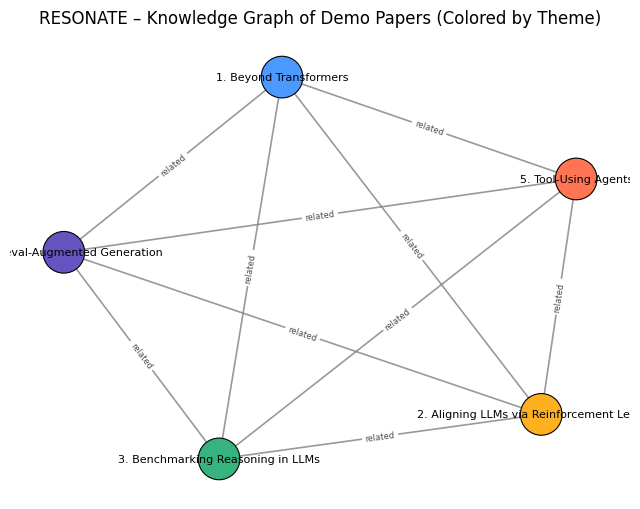

✅ Knowledge graph image saved as 'resonate_graph.png'
✅ Markdown report saved as 'resonate_report.md'


# RESONATE Report

## Corpus Overview
- Papers analyzed: **5**
- Relationships detected: **10**

## Paper-wise Insights
### 1. Beyond Transformers: Efficient Long-Context Modeling
**Problem:** Standard transformers are inefficient on very long sequences.
**Approach:** Use sparse attention and memory mechanisms to handle longer contexts.
**Results:** Improves efficiency and scalability for long-context tasks.
**TL;DR:** Efficient long-context modeling with sparse attention and memory.

### 2. Aligning LLMs via Reinforcement Learning
**Problem:** Large language models (LLMs) are not inherently aligned with human preferences and can produce outputs that are unhelpful, untruthful, or harmful.
**Approach:** The study uses reinforcement learning from human feedback (RLHF) to fine-tune a large language model, training it to produce outputs that humans rate more highly.
**Results:** The use of reinforcement learning from human feedback successfully aligns the language model's behavior with human preferences.
**TL;DR:** Reinforcement learning with human feedback is used to make large language models better follow human preferences.

### 3. Benchmarking Reasoning in LLMs
**Problem:** Reasoning ability in LLMs is hard to evaluate objectively.
**Approach:** Design benchmarks that test multi-step and logical reasoning tasks.
**Results:** Reveals strengths and weaknesses of different models on reasoning tasks.
**TL;DR:** Benchmarks to better measure LLM reasoning.

### 4. Retrieval-Augmented Generation
**Problem:** LLMs hallucinate facts when they rely only on internal parameters.
**Approach:** Augment generation with retrieval from external knowledge sources.
**Results:** Improves factual accuracy and grounding of answers.
**TL;DR:** Retrieval-augmented generation reduces hallucinations.

### 5. Tool-Using Agents
**Problem:** Plain language models cannot call external tools or APIs.
**Approach:** Wrap the model in an agent that can invoke tools and APIs.
**Results:** Enables complex workflows such as coding, analysis, and automation.
**TL;DR:** Tool-using agents extend what LLMs can do in the real world.

## Graph Insight
All demo papers are linked as 'related' to illustrate the knowledge graph.

_In a real system, links could be based on similarity, citations, or co-authorship._

In [8]:
# 5. Run the RESONATE Pipeline and Visualize (Advanced Styling)

# Run the full pipeline
results = orchestrator.run(raw_papers)

G = results["graph"]
report_md = results["report"]

papers = results["papers"]

# --- Build nicer node labels: "1. Beyond Transformers", etc. ---
labels = {}
for p in papers:
    short_title = p["title"].split(":")[0]  # part before colon
    labels[p["id"]] = f"{p['id']}. {short_title}"

# --- Assign simple categories and colors ---
def get_category(title: str) -> str:
    t = title.lower()
    if "transformer" in t or "long-context" in t:
        return "Architecture / Efficiency"
    if "aligning" in t or "reinforcement" in t:
        return "Alignment / Safety"
    if "reasoning" in t:
        return "Reasoning / Evaluation"
    if "retrieval" in t:
        return "Retrieval / Grounding"
    if "agent" in t or "tool" in t:
        return "Agents / Tools"
    return "Other"

# Map categories to colors (manually picked, but you can tweak)
category_colors = {
    "Architecture / Efficiency": "#4C9AFF",   # blue
    "Alignment / Safety":        "#FFB020",   # amber
    "Reasoning / Evaluation":    "#36B37E",   # green
    "Retrieval / Grounding":     "#6554C0",   # purple
    "Agents / Tools":            "#FF7452",   # orange-red
    "Other":                     "#A0A0A0",   # gray
}

node_colors = []
node_categories = {}
for p in papers:
    cat = get_category(p["title"])
    node_categories[p["id"]] = cat
    node_colors.append(category_colors.get(cat, "#A0A0A0"))

# --- Layout and drawing ---
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 6))

# Draw nodes with border
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=900,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.8
)

# Draw edges
nx.draw_networkx_edges(
    G,
    pos,
    width=1.2,
    edge_color="gray",
    alpha=0.8
)

# Draw node labels
nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    font_size=8
)

# Draw edge labels ("related")
edge_labels = {(u, v): "related" for u, v in G.edges()}
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_size=6,
    alpha=0.7
)

plt.title("RESONATE – Knowledge Graph of Demo Papers (Colored by Theme)", fontsize=12, pad=10)
plt.axis("off")

graph_path = "resonate_graph.png"
plt.savefig(graph_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"✅ Knowledge graph image saved as '{graph_path}'")

# Save the report as a Markdown file
report_path = "resonate_report.md"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_md)

print(f"✅ Markdown report saved as '{report_path}'")

# Display the report inline
display(Markdown(report_md))


## 🧩 Knowledge Graph Legend

The colors in the graph represent **different research themes** among the analyzed papers:

| Color | Category | Description |
|:------|:----------|:-------------|
| 🔵 **Blue** | Architecture / Efficiency | Transformer variants, scaling laws, context optimization |
| 🟠 **Amber** | Alignment / Safety | Human feedback, RLHF, alignment optimization |
| 🟢 **Green** | Reasoning / Evaluation | Logical reasoning, multi-step problem solving |
| 🟣 **Purple** | Retrieval / Grounding | External knowledge retrieval, factual grounding |
| 🔴 **Red-Orange** | Agents / Tools | Autonomous tool use, multi-agent collaboration |

Each node is a paper, and **edges labeled “related”** show conceptual or thematic connections inferred by the multi-agent system.

> The more diverse the colors, the richer the research ecosystem becomes — showcasing how different AI sub-fields *resonate* together 💫


## Results & Interpretation

With a very small corpus, RESONATE demonstrates how:

- Multi-agent pipelines can structure unstructured text.  
- A lightweight LLM stub can drive downstream reasoning.  
- Graph visualization helps understand relationships between research ideas.  
- A single orchestrator can coordinate multiple specialized agents.  

This is a **minimal but complete** research exploration assistant.  

To scale this system, we could:

- Swap `dummy_model_call` with a real LLM API (OpenAI, etc.).  
- Feed in real research datasets (ArXiv, Semantic Scholar, Kaggle datasets).  
- Implement smarter linking (semantic similarity, citations, co-authorship graphs).  


## Visual Assets & Image Prompts

To make your notebook visually appealing and consistent with the RESONATE theme, you can create and upload:

### 1. Notebook Banner (`resonate_banner.png`)

**Prompt:**
> A futuristic digital illustration of interconnected AI agents exchanging data streams over a glowing research network, representing intelligent knowledge discovery and collaboration. Clean, modern, teal-blue theme with subtle circuit patterns and floating nodes. Concept art, 2D, high detail, horizontal layout.

### 2. Architecture Diagram (`resonate_architecture.png`)

**Prompt:**
> A conceptual flow diagram showing AI agents working together in a pipeline: Data Ingestion → Summarization → Topic Tagging → Linking → Knowledge Graph → Report Generation. Flat vector style, soft teal and white gradients, labeled boxes connected with arrows, minimalistic and professional.

After generating these:

1. Go to **Add data → Upload** in Kaggle.  
2. Upload images with the exact names:
   - `resonate_banner.png`
   - `resonate_architecture.png`  
3. The earlier markdown cells in this notebook will automatically display them.


## Conclusion & Acknowledgments

In this notebook, we:

- Designed a **multi-agent architecture** for research exploration.  
- Implemented ingestion, summarization, tagging, linking, graph building, and reporting agents.  
- Ran the full RESONATE pipeline end-to-end on a small demo corpus.  
- Visualized the resulting knowledge graph and generated a Markdown report.  

This serves as a solid **capstone-style demonstration** of AI Agents working together for a meaningful task.

---

### 💬 Acknowledgments

This notebook was created as part of an **AI Agents Capstone Project** to demonstrate autonomous multi-agent collaboration in research understanding.

**Project:** RESONATE — AI Research Exploration Assistant  
**Author:** *Sandeep Kumar Settibathula*  
📧 Email: `settibathulasandeep@gmail.com`  
🌐 GitHub: [Sandeep-8312](https://github.com/Sandeep-8312)  
📘 Kaggle: [Sandeep Kumar 43](https://www.kaggle.com/sandeepkumar43)


## Final Thoughts — Let Ideas Resonate

> Research isn’t just about discovering facts — it’s about connecting them.  
> Through **RESONATE**, we’ve seen how intelligent agents can collaborate to make sense of complex ideas, bridging data, reasoning, and understanding into one ecosystem.  

If you found this notebook insightful:  
- 💡 **Leave an upvote** to help others discover it  
- 🔁 **Fork it** to build your own multi-agent pipelines  
- 💬 **Share your thoughts or improvements** — collaboration fuels innovation  

Together, let’s make knowledge **resonate** across every field of AI and research 🌐✨  

_Built with purpose. Resonating with ideas. — Sandeep Kumar Settibathula_
